In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from xgboost import XGBRegressor

!pip install -q shap
import shap

import os
import json
import copy

!pip install -q joblib
import joblib

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
corDefault = "#6688AA"
corViridis = ['#440154', '#414487', '#2a788e', '#22a884', '#7ad151']
colorss = ['#b2c3d4', '#414487', '#B01756']

def set_plot_style():
    # Background colors
    plt.figure().patch.set_facecolor("0.85")
    plt.axes().set(facecolor="0.85")
    
    # Hiding grid
    plt.grid(False)
    
    # Setting only left and bottom spines as visible
    ax = plt.gca()
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Spines color
    ax.spines['bottom'].set_color("black")
    ax.spines['left'].set_color("black")
    
    # Plot size
    plt.gcf().set_size_inches(6, 5)

    # Plot Style
    plt.style.use('seaborn-v0_8-colorblind')

# **DATASET LOADING**

In [5]:
df_train = pd.read_csv('../data/processed/02_Train.csv')

df_val = pd.read_csv('../data/processed/02_Validation.csv')

df_test = pd.read_csv('../data/processed/02_Test.csv')

df = pd.date_range(start = '2025-03-01', end = '2025-04-30', freq = 'D')
df = pd.DataFrame({'date': df})

# **DATASET SPLITTING**

In [7]:
X_train = df_train.drop('sell_quantity_log', axis = 1).copy()
y_train = df_train['sell_quantity_log'].copy()

X_val = df_val.drop('sell_quantity_log', axis = 1).copy()
y_val = df_val['sell_quantity_log'].copy()

X_test = df_test.drop('sell_quantity_log', axis = 1).copy()
y_test = df_test['sell_quantity_log'].copy()

# **MODEL DEVELOPMENT AND EVALUATION**

## **MODEL DEVELOPMENT**

In [10]:
def create_model():
    return XGBRegressor(
        n_estimators = 500,
        learning_rate = 0.05,
        max_depth = 5,
        subsample = 0.8,
        colsample_bytree = 0.8,
        random_state = 13,
        early_stopping_rounds = 20,
        eval_metric = 'rmse'
    )

model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [11]:
y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df = pd.DataFrame({
    'Results_1': [round(mae, 3), round(rmse, 3), round(r2, 4)]},
                          index=['MAE', 'RMSE', 'R²'])

metrics_df

,Results_1
MAE,0.1130
RMSE,0.1710
R²,0.9927


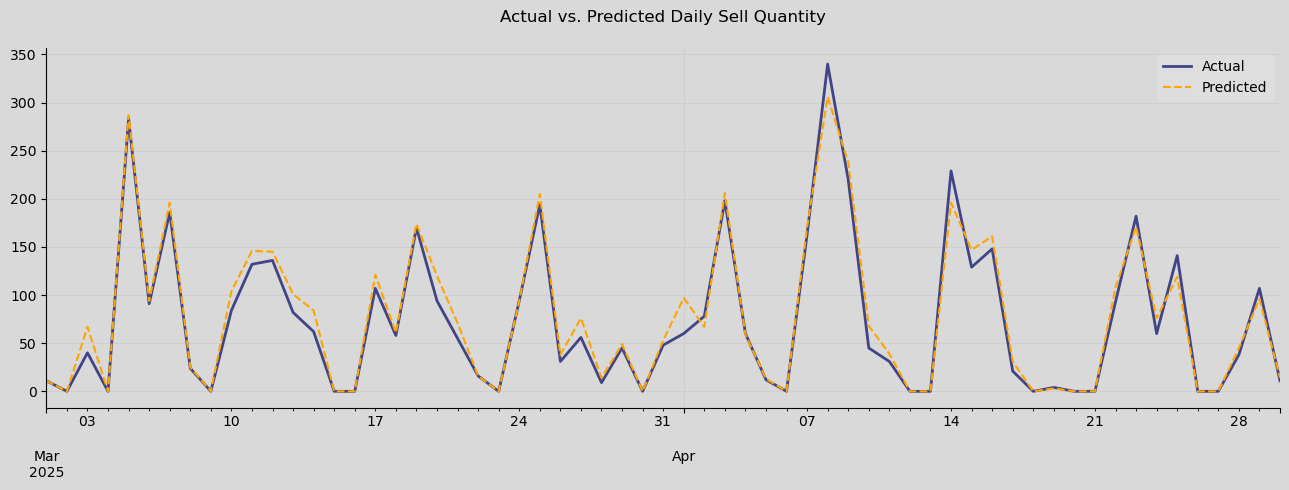

In [12]:
def PlotActPred(df, save):
    set_plot_style()
    df.set_index('date')['y_test'].plot(color = corViridis[1], linewidth = 2, label = 'Actual')
    df.set_index('date')['y_pred'].plot(color = 'orange', label = 'Predicted', linestyle = '--')
    plt.title('Actual vs. Predicted Daily Sell Quantity\n')
    legend = plt.legend()
    legend.get_frame().set_facecolor('0.88')
    legend.get_frame().set_edgecolor('0.88')
    plt.grid(visible = True, color = '0.81')
    plt.xlabel("")
    plt.ylabel("")
    plt.gcf().set_size_inches(13, 5)
    
    plt.tight_layout()
    plt.savefig(save)
    
    plt.show()
    plt.close()


PlotActPred(df, "../visuals/43.ActualvPredictedDailySellQuantity.svg")

## **MODEL REFINEMENT**

### **FEATURE IMPORTANCE**

In [15]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

result = permutation_importance(model, X_val, y_val, n_repeats = 10, random_state = 13)

xgb_importance = pd.Series(model.feature_importances_, index = X_val.columns, name = "XGB Importance")
shap_importance = pd.Series(np.abs(shap_values).mean(axis = 0), index = X_val.columns, name = "SHAP Importance")
perm_importance = pd.Series(result.importances_mean, index = X_val.columns, name = "Permutation Importance")

importances_df = pd.concat([xgb_importance, shap_importance, perm_importance], axis = 1)
importances_df = importances_df.sort_values("SHAP Importance", ascending = False)
importances_df

,XGB Importance,SHAP Importance,Permutation Importance
inventory_turnover,0.487695,1.133275,0.667692
sell_value,0.106115,0.341238,0.066904
inventory_lag_1,0.011636,0.257757,0.017608
daily_balance,0.023839,0.221135,0.136855
is_weekend,0.308086,0.150041,0.032376
buy_quantity,0.011233,0.139991,0.025222
rolling_std_sell_value,0.005392,0.017223,-0.000179
incc_monthly_change,0.002690,0.016385,-0.000611
fuel_price_vs_buy_value,0.003479,0.013037,-0.001049
month,0.011947,0.011357,0.000063


All three importance metrics for `fuel_price_pct_change` (XGBoost gain, SHAP, and permutation importance) returned a value of zero.

This confirms that the feature is not being utilized by the model in any meaningful way. Given its redundancy or lack of predictive contribution, we will remove this feature and retrain the model to evaluate any changes in performance.

In [17]:
X_train = X_train.drop('fuel_price_pct_change', axis = 1).copy()
X_val = X_val.drop('fuel_price_pct_change', axis = 1).copy()
X_test = X_test.drop('fuel_price_pct_change', axis = 1).copy()

In [18]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [19]:
y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_2"] = [round(mae, 3), round(rmse, 3), round(r2, 4)]
metrics_df

,Results_1,Results_2
MAE,0.1130,0.1090
RMSE,0.1710,0.1700
R²,0.9927,0.9928


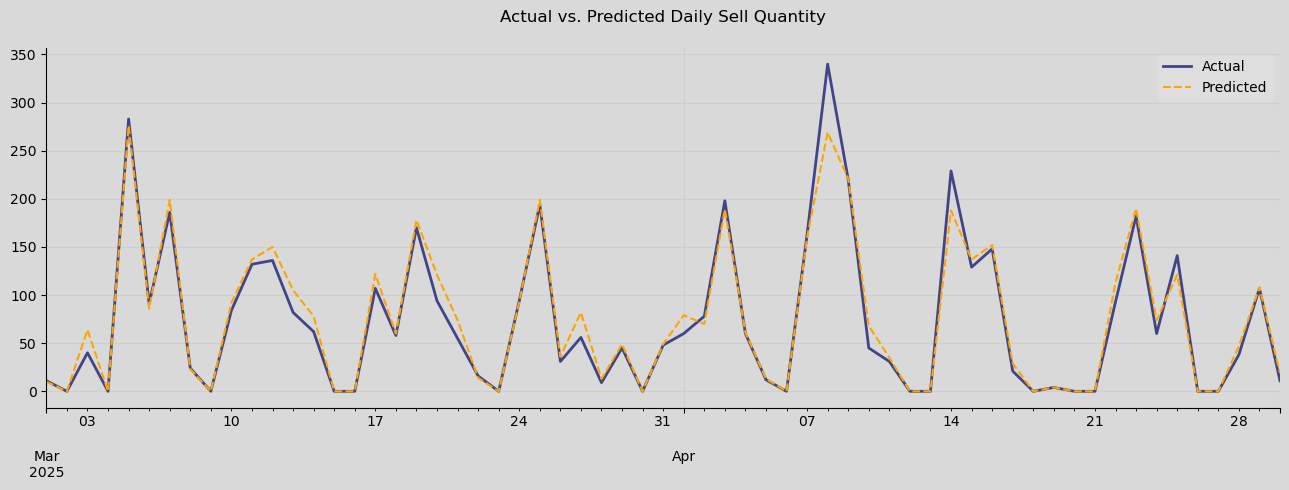

In [20]:
PlotActPred(df, "../visuals/44.ActualvPredictedDailySellQuantity.svg")

After excluding the `fuel_price_pct_change` feature, model performance slightly improved across all key metrics. This confirms that the feature was not only unused, but also introduced noise. Its removal helped the model generalize slightly better on unseen data.

In [22]:
model_v1 = copy.deepcopy(model)

### **RESIDUAL ANALYSIS**

In [24]:
df['residuals'] = df['y_test'] - df['y_pred']

df_test2 = df_test.copy()
df_test2['date'] = df['date'].copy()
df_test2['residuals'] = df['residuals'].copy()
df_test2['predicted'] = df['y_pred'].copy()
df_test2['abs_error'] = df_test2['residuals'].abs()
df_test2['y_test'] = df['y_test'].copy()

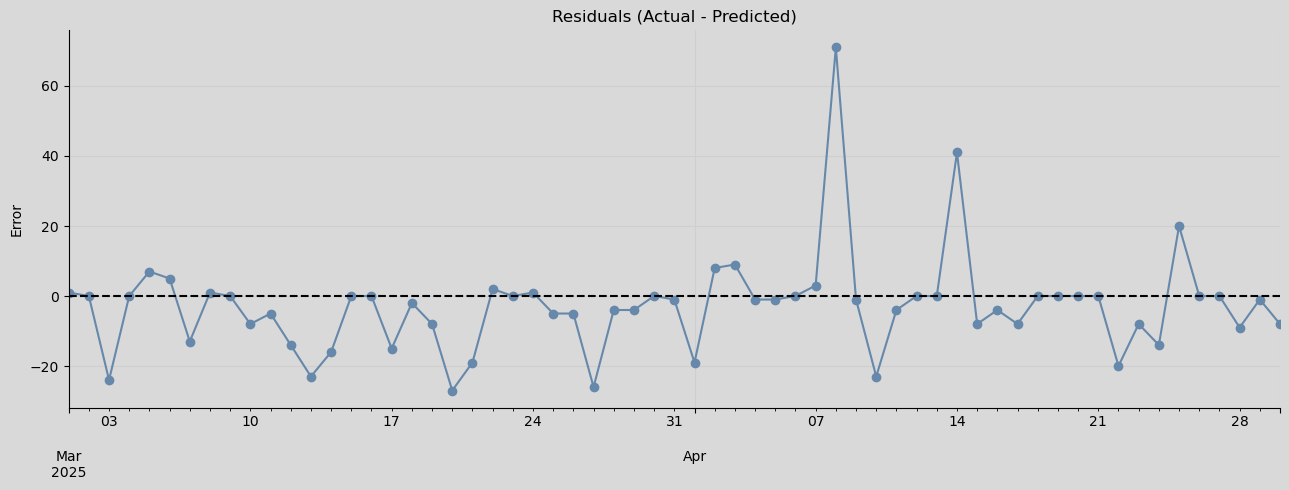

In [25]:
set_plot_style()
df_test2.set_index('date')['residuals'].plot(color = corDefault, marker = 'o', linestyle = '-')
plt.axhline(0, color = 'black', linestyle = '--')
plt.title('Residuals (Actual - Predicted)')

plt.grid(visible = True, color = '0.81')
plt.xlabel("")
plt.ylabel('Error')
plt.gcf().set_size_inches(13, 5)

plt.tight_layout()
plt.savefig("../visuals/45.ResidualsPlot.svg")

plt.show()
plt.close()

We'll initiate a targeted residual analysis to better understand the conditions under which the model tends to make large prediction errors.

Throughout this phase, scatterplots with trend lines will be used to evaluate the relationship between absolute prediction error (`abs_error`) and selected features. This will guide the creation of new features (e.g., binary flags or binned categories) and the removal of others that appears to introduce noise or offer no predictive value.

Since these refinements are based on residuals from a fixed test window (March–April 2025), there is a potential risk of overfitting to this specific slice of data, to ensure that improvements generalize beyond this window, the following validation strategies will be applied after the residual-driven adjustments:
- Time-aware cross-validation or walk-forward validation on future data;
- Performance comparison with a frozen baseline model (`v1`);
- Monitoring of prediction drift or error concentration when deployed in production;
- A/B testing integrated into an operational pricing workflow.

In [27]:
cols = [
    'precipitation',
    'incc_monthly_change',
    'inventory_turnover',
    'sell_quantity_lag_7',
    'sell_value',
    'rolling_std_sell_value',
    'daily_balance',
    'buy_quantity',
    'inventory_lag_1',
    'incc_lag_2_month',
    'fuel_price_vs_buy_value',
    'fuel_price_lag_60',
    'days_until_holiday'
]

cols_desc =[
    'Impact of Precipitation on Prediction Error',
    'Model Error Across INCC Variation',
    'Prediction Error by Inventory Turnover',
    'Prediction Error vs. Prior Week’s Demand',
    'Prediction Error vs. Sell Value',
    'Model Error Across Rolling Std of Sell Value',
    'Prediction Error vs. Daily Balance',
    'Impact of Quantity Bought on Prediction Error',
    'Prediction Error vs. Prior Day’s Inventory',
    'Prediction Error vs. Two Month’s INCC Index',
    'Prediction Error by Fuel Price vs. Buy Value',
    'Prediction Error vs. Two Month’s Fuel Price',
    'Impact of Holiday Antecipation on Prediction Error'
]

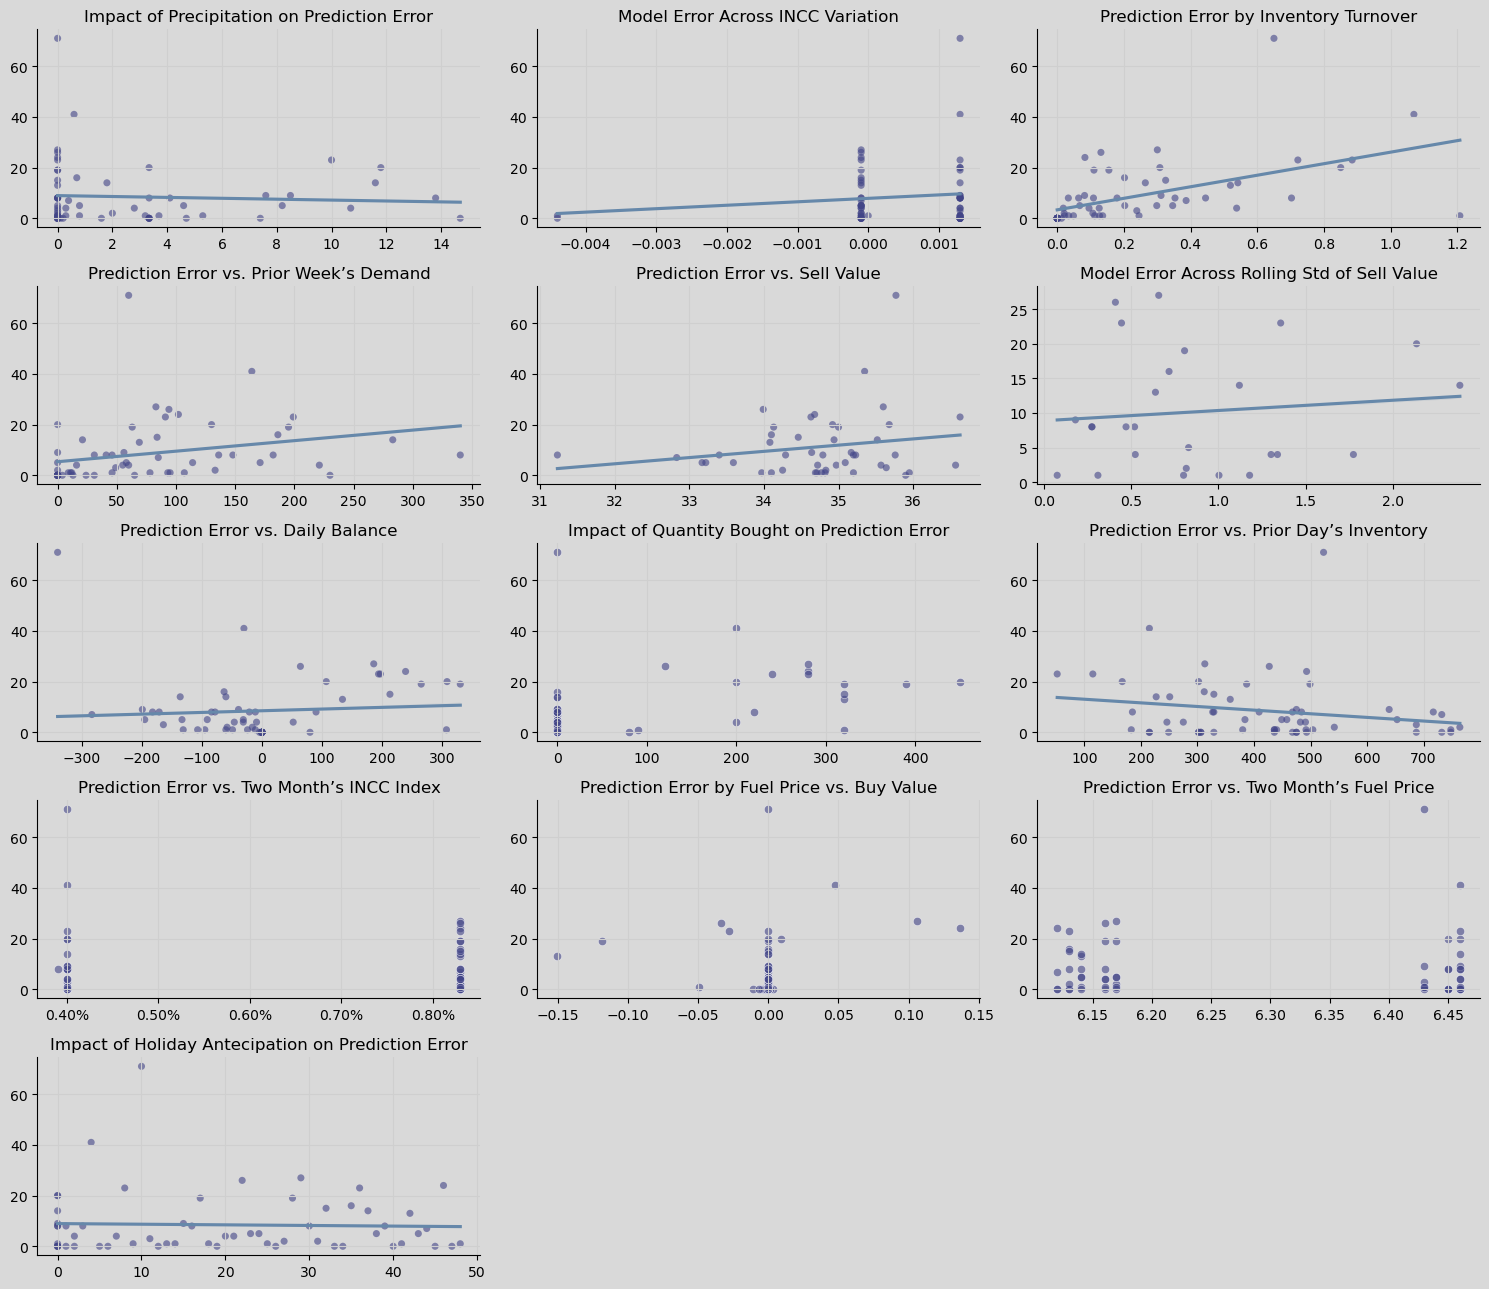

In [28]:
fig, axs = plt.subplots(5, 3, figsize = (15, 13))
fig.patch.set_facecolor("0.85")

c = int(0)
for i in range(5):
    for j in range(3):
        if ((i == 4) & (j > 0)):
            axs[i,j].axis('off')
            c += 1
        else:
            if (c == int(1) | c == int(9)):
                axs[i,j].grid(visible = True, color = '0.81')
                sns.scatterplot(data = df_test2, x = cols[c], y = 'abs_error', alpha = 0.6, ax = axs[i,j], color = corViridis[1])
                axs[i,j].set_title(cols_desc[c])
                axs[i,j].set_ylabel("")
                axs[i,j].set_xlabel("")
                axs[i,j].xaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1, decimals = 2))
                axs[i,j].spines.right.set_visible(False)
                axs[i,j].spines.top.set_visible(False)
                axs[i,j].set_facecolor("0.85")
                c += 1
            elif ((c == int(7)) | ((c > int(9)) & (c <= int(11)))):
                axs[i,j].grid(visible = True, color = '0.81')
                sns.scatterplot(data = df_test2, x = cols[c], y = 'abs_error', alpha = 0.6, ax = axs[i,j], color = corViridis[1])
                axs[i,j].set_title(cols_desc[c])
                axs[i,j].set_ylabel("")
                axs[i,j].set_xlabel("")
                axs[i,j].spines.right.set_visible(False)
                axs[i,j].spines.top.set_visible(False)
                axs[i,j].set_facecolor("0.85")
                c += 1
            else:
                axs[i,j].grid(visible = True, color = '0.81')
                sns.regplot(data = df_test2, x = cols[c], y = 'abs_error', scatter = True, color = corViridis[1],
                            scatter_kws = {"s": 26, "alpha": 0.6, "edgecolors": "none"},
                            ci = True, line_kws = {"color": corDefault},
                            ax = axs[i,j])
                axs[i,j].set_title(cols_desc[c])
                axs[i,j].set_ylabel("")
                axs[i,j].set_xlabel("")
                axs[i,j].spines.right.set_visible(False)
                axs[i,j].spines.top.set_visible(False)
                axs[i,j].set_facecolor("0.85")
                c += 1

plt.tight_layout()
plt.savefig("../visuals/46.AbsoluteErrorScatterPlot.svg")
plt.show()
plt.close()

Findings:
- `precipitation`: Most high-error points occurred on dry days ($precipitation = 0$). The model does not seem to capture any demand variability related to rainfall. This feature may be redundant;
- `incc_monthly_change`: Most values are near 0%, and high-error points are spread across small positive values. There is no clear signal that this feature contributes meaningfully to prediction error. It may be safely removed or deprioritized in the model;
- `inventory_turnover`: The trend line shows a consistent upward slope, indicating growing error as turnover increases. A binned category will be created to help the model anticipate high-demand, low-stock scenarios;
- `sell_quantity_lag_7`: Although there is a slight upward trend, the pattern is weaker than initially expected. A binned category will also be created using quantiles;
- `rolling_std_sell_value`: Most errors occur when this feature is active, with no clear predictive pattern. It may introduce noise and will be removed from the model;
- `daily_balance`: Residual analysis shows that most high-error predictions occurrs when the daily balance is positive. A binary flag may be introduced to assess this;
- `buy_quantity`: While the feature in its continuous form shows little correlation with prediction error, errors are notably more severe when no purchase occurrs;
- `incc_lag_2_month`: The feature appears to offer only categorical granularity, with values clustered around two fixed points;
- `fuel_price_vs_buy_value`: The distribution of values and errors suggests this features behaves like a binary indicator. Binary flags may be introduced to assess this;
- `fuel_price_lag_60`: The feature shows low variability and no visual relationship with prediction error. The feature will be removed to evaluate its impact on the model.

In [30]:
i_train = X_train.copy()
i_val = X_val.copy()
i_test = X_test.copy()

X_train['no_rain'] = (X_train['precipitation'] > 0.1).astype(int)
X_val['no_rain'] = (X_val['precipitation'] > 0.1).astype(int)
X_test['no_rain'] = (X_test['precipitation'] > 0.1).astype(int)

In [31]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_3"] = [round(mae, 3), round(rmse, 3), round(r2, 4)]
metrics_df

,Results_1,Results_2,Results_3
MAE,0.1130,0.1090,0.1130
RMSE,0.1710,0.1700,0.1710
R²,0.9927,0.9928,0.9927


In [32]:
X_train = i_train.copy()
X_val = i_val.copy()
X_test = i_test.copy()

A binary flag indicating whether it had rained was created, since high-error points occurred on dry days. Since model performance worsened, it will be removed.

In [34]:
i_train = X_train.copy()
X_train = X_train.drop('incc_monthly_change', axis = 1).copy()

i_val = X_val.copy()
X_val = X_val.drop('incc_monthly_change', axis = 1).copy()

i_test = X_test.copy()
X_test = X_test.drop('incc_monthly_change', axis = 1).copy()

In [35]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_3"] = [round(mae, 3), round(rmse, 3), round(r2, 4)]
metrics_df

,Results_1,Results_2,Results_3
MAE,0.1130,0.1090,0.1170
RMSE,0.1710,0.1700,0.1700
R²,0.9927,0.9928,0.9928


Metrics before and after removal of `incc_monthly_change` showed no change in RMSE or R², and only a minor increase in MAE (+0.008). To simplify the model, reduce complexity, and eliminate any potential redundancy with other economic indicators the feature will be removed.

In [37]:
X_train['turnover_bin'] = pd.qcut(
    X_train['inventory_turnover'],
    q = 4,
    labels = [0, 1, 2 ,3]  #0:"very low", 1: "low", 2: "mid", 3: "high"
).fillna(0).astype(int)

X_val['turnover_bin'] = pd.qcut(
    X_val['inventory_turnover'],
    q = 4,
    labels = [0, 1, 2 ,3]  #0:"very low", 1: "low", 2: "mid", 3: "high"
).astype(int)

X_test['turnover_bin'] = pd.qcut(
    X_test['inventory_turnover'],
    q = 4,
    labels = [0, 1, 2 ,3]  #0:"very low", 1: "low", 2: "mid", 3: "high"
).astype(int)

In [38]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_4"] = [round(mae, 3), round(rmse, 3), round(r2, 4)]
metrics_df

,Results_1,Results_2,Results_3,Results_4
MAE,0.1130,0.1090,0.1170,0.1110
RMSE,0.1710,0.1700,0.1700,0.1700
R²,0.9927,0.9928,0.9928,0.9928


In [39]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

result = permutation_importance(model, X_val, y_val, n_repeats = 10, random_state = 13)

xgb_importance = pd.Series(model.feature_importances_, index = X_val.columns, name = "XGB Importance")
shap_importance = pd.Series(np.abs(shap_values).mean(axis = 0), index = X_val.columns, name = "SHAP Importance")
perm_importance = pd.Series(result.importances_mean, index = X_val.columns, name = "Permutation Importance")

importances_df = pd.concat([xgb_importance, shap_importance, perm_importance], axis = 1)
importances_df = importances_df.sort_values("SHAP Importance", ascending = False)
importances_df

,XGB Importance,SHAP Importance,Permutation Importance
inventory_turnover,0.322921,1.057487,0.584425
sell_value,0.097034,0.348797,0.075658
inventory_lag_1,0.007589,0.262310,0.024810
daily_balance,0.014003,0.198304,0.141340
buy_quantity,0.007643,0.138405,0.019741
is_weekend,0.209501,0.131731,0.028104
turnover_bin,0.322226,0.100494,0.008773
fuel_price_lag_60,0.002063,0.024642,-0.000010
rolling_std_sell_value,0.003152,0.022123,-0.000938
fuel_price_vs_buy_value,0.001729,0.011810,-0.000682


After adding the categorical feature `turnover_bin`, and evaluating its effect on model performance and importance metrics, it was proved that the model benefits from having both the continuous form and its binned version. Both will be retained.

In [41]:
X_train['lag_7_bin'] = pd.qcut(
    X_train['sell_quantity_lag_7'],
    q = 4,
    labels = [0, 1, 2, 3]
).fillna(0).astype(int)

X_val['lag_7_bin'] = pd.qcut(
    X_val['sell_quantity_lag_7'],
    q = 4,
    labels = [0, 1, 2, 3]
).astype(int)

X_test['lag_7_bin'] = pd.qcut(
    X_test['sell_quantity_lag_7'],
    q = 4,
    labels = [0, 1, 2, 3]
).astype(int)

In [42]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_5"] = [round(mae, 3), round(rmse, 3), round(r2, 4)]
metrics_df

,Results_1,Results_2,Results_3,Results_4,Results_5
MAE,0.1130,0.1090,0.1170,0.1110,0.0940
RMSE,0.1710,0.1700,0.1700,0.1700,0.1480
R²,0.9927,0.9928,0.9928,0.9928,0.9945


In [43]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

result = permutation_importance(model, X_val, y_val, n_repeats = 10, random_state = 13)

xgb_importance = pd.Series(model.feature_importances_, index = X_val.columns, name = "XGB Importance")
shap_importance = pd.Series(np.abs(shap_values).mean(axis = 0), index = X_val.columns, name = "SHAP Importance")
perm_importance = pd.Series(result.importances_mean, index = X_val.columns, name = "Permutation Importance")

importances_df = pd.concat([xgb_importance, shap_importance, perm_importance], axis = 1)
importances_df = importances_df.sort_values("SHAP Importance", ascending = False)
importances_df

,XGB Importance,SHAP Importance,Permutation Importance
inventory_turnover,0.391221,1.102031,0.637981
sell_value,0.056959,0.322367,0.064068
inventory_lag_1,0.009026,0.283233,0.020131
daily_balance,0.012787,0.197257,0.111351
buy_quantity,0.008109,0.141747,0.023077
is_weekend,0.123936,0.126614,0.028970
turnover_bin,0.377860,0.094932,0.005874
rolling_std_sell_value,0.002620,0.015605,-0.000233
days_until_holiday,0.000400,0.012216,-0.000003
month,0.011193,0.011675,0.000006


In [44]:
i_train = X_train['rolling_std_sell_value'].copy()
X_train = X_train.drop('rolling_std_sell_value', axis = 1).copy()

i_val = X_val['rolling_std_sell_value'].copy()
X_val = X_val.drop('rolling_std_sell_value', axis = 1).copy()

i_test = X_test['rolling_std_sell_value'].copy()
X_test = X_test.drop('rolling_std_sell_value', axis = 1).copy()

In [45]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_6"] = [round(mae, 3), round(rmse, 3), round(r2, 4)]
metrics_df

,Results_1,Results_2,Results_3,Results_4,Results_5,Results_6
MAE,0.1130,0.1090,0.1170,0.1110,0.0940,0.0960
RMSE,0.1710,0.1700,0.1700,0.1700,0.1480,0.1470
R²,0.9927,0.9928,0.9928,0.9928,0.9945,0.9946


Although the removal of this feature had only a minor impact on RMSE and R², it slightly improved model generalization while simplifying the feature set. Visual analysis showed no clear relationship with prediction error, and the feature appeared to introduce mild noise. Its exclusion was retained to enhance model stability and interpretability without compromising performance.

In [47]:
X_train['is_positive_daily_balance'] = (X_train['daily_balance'] > 0).astype(int)

X_val['is_positive_daily_balance'] = (X_val['daily_balance'] > 0).astype(int)

X_test['is_positive_daily_balance'] = (X_test['daily_balance'] > 0).astype(int)

In [48]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_7"] = [round(mae, 3), round(rmse, 3), round(r2, 4)]
metrics_df

,Results_1,Results_2,Results_3,Results_4,Results_5,Results_6,Results_7
MAE,0.1130,0.1090,0.1170,0.1110,0.0940,0.0960,0.102
RMSE,0.1710,0.1700,0.1700,0.1700,0.1480,0.1470,0.142
R²,0.9927,0.9928,0.9928,0.9928,0.9945,0.9946,0.995


A binary flag indicating whether daily balance is positive was created since the plot showed that errors increased when the daily balance was positive. The model showed a slight increase in MAE (+0.006), but improved in RMSE and R². This suggests that the flag helps the model handle high-error days with excess purchases. It is retained for its strategic value and interpretability.

In [50]:
X_train['did_buy'] = (X_train['buy_quantity'] > 0).astype(int)

X_val['did_buy'] = (X_val['buy_quantity'] > 0).astype(int)

X_test['did_buy'] = (X_test['buy_quantity'] > 0).astype(int)

In [51]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_8"] = [round(mae, 3), round(rmse, 3), round(r2, 4)]
metrics_df

,Results_1,Results_2,Results_3,Results_4,Results_5,Results_6,Results_7,Results_8
MAE,0.1130,0.1090,0.1170,0.1110,0.0940,0.0960,0.102,0.0850
RMSE,0.1710,0.1700,0.1700,0.1700,0.1480,0.1470,0.142,0.1330
R²,0.9927,0.9928,0.9928,0.9928,0.9945,0.9946,0.995,0.9956


A binary flag indicating whether any purchase occurred on a given day was created, beacause visual residual analysis showed that the model frequently struggled on days with zero purchases, especially with outliers. Introducing this flag significantly improved model performance. Given the strength of this result, we'll proceed to evaluate whether the original continuous variable `buy_quantity` is still contributing meaningfully to model performance.

In [53]:
i_train = X_train.copy()
X_train = X_train.drop('buy_quantity', axis = 1).copy()

i_val = X_val.copy()
X_val = X_val.drop('buy_quantity', axis = 1).copy()

i_test = X_test.copy()
X_test = X_test.drop('buy_quantity', axis = 1).copy()

In [54]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_9"] = [round(mae, 3), round(rmse, 3), round(r2, 4)]
metrics_df

,Results_1,Results_2,Results_3,Results_4,Results_5,Results_6,Results_7,Results_8,Results_9
MAE,0.1130,0.1090,0.1170,0.1110,0.0940,0.0960,0.102,0.0850,0.1020
RMSE,0.1710,0.1700,0.1700,0.1700,0.1480,0.1470,0.142,0.1330,0.1520
R²,0.9927,0.9928,0.9928,0.9928,0.9945,0.9946,0.995,0.9956,0.9942


In [55]:
X_train = i_train.copy()
X_val = i_val.copy()
X_test = i_test.copy()

The results shows a significant decline in all performance metrics if `buy_quantity` is removed. This indicates that the continuous value of `buy_quantity` still provides meaningful signal beyond the binary flag. As a result, both `buy_quantity` and `did_buy` are retained in the final model.

In [57]:
i_train = X_train.copy()
X_train = X_train.drop('incc_lag_2_month', axis = 1).copy()

i_val = X_val.copy()
X_val = X_val.drop('incc_lag_2_month', axis = 1).copy()

i_test = X_test.copy()
X_test = X_test.drop('incc_lag_2_month', axis = 1).copy()

In [58]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_9"] = [round(mae, 3), round(rmse, 3), round(r2, 4)]
metrics_df

,Results_1,Results_2,Results_3,Results_4,Results_5,Results_6,Results_7,Results_8,Results_9
MAE,0.1130,0.1090,0.1170,0.1110,0.0940,0.0960,0.102,0.0850,0.0940
RMSE,0.1710,0.1700,0.1700,0.1700,0.1480,0.1470,0.142,0.1330,0.1370
R²,0.9927,0.9928,0.9928,0.9928,0.9945,0.9946,0.995,0.9956,0.9953


In [59]:
X_train = i_train.copy()
X_val = i_val.copy()
X_test = i_test.copy()

Although the feature appears to contain limited granularity and exhibits no clear relationship with error, its removal led to a drop in model performance across all key metrics. This suggests the model extracts subtle but useful signals from it. The feature is retained.

In [61]:
i_train = X_train.copy()
i_val = X_val.copy()
i_test = X_test.copy()

X_train['fuel_vs_buy_zero'] = (X_train['fuel_price_vs_buy_value'] == 0).astype(int)
X_train['fuel_vs_buy_nonzero'] = (X_train['fuel_price_vs_buy_value'] != 0).astype(int)

X_val['fuel_vs_buy_zero'] = (X_val['fuel_price_vs_buy_value'] == 0).astype(int)
X_val['fuel_vs_buy_nonzero'] = (X_val['fuel_price_vs_buy_value'] != 0).astype(int)

X_test['fuel_vs_buy_zero'] = (X_test['fuel_price_vs_buy_value'] == 0).astype(int)
X_test['fuel_vs_buy_nonzero'] = (X_test['fuel_price_vs_buy_value'] != 0).astype(int)

In [62]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_9"] = [round(mae, 3), round(rmse, 3), round(r2, 4)]
metrics_df

,Results_1,Results_2,Results_3,Results_4,Results_5,Results_6,Results_7,Results_8,Results_9
MAE,0.1130,0.1090,0.1170,0.1110,0.0940,0.0960,0.102,0.0850,0.1060
RMSE,0.1710,0.1700,0.1700,0.1700,0.1480,0.1470,0.142,0.1330,0.1730
R²,0.9927,0.9928,0.9928,0.9928,0.9945,0.9946,0.995,0.9956,0.9926


In [63]:
X_train = i_train.copy()
X_val = i_val.copy()
X_test = i_test.copy()

The introduction of binary indicators significantly worsened model performance across all key metrics. This new feature will not be used.

In [65]:
i_train = X_train.copy()
X_train = X_train.drop('fuel_price_vs_buy_value', axis = 1).copy()

i_val = X_val.copy()
X_val = X_val.drop('fuel_price_vs_buy_value', axis = 1).copy()

i_test = X_test.copy()
X_test = X_test.drop('fuel_price_vs_buy_value', axis = 1).copy()

In [66]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_9"] = [round(mae, 3), round(rmse, 3), round(r2, 4)]
metrics_df

,Results_1,Results_2,Results_3,Results_4,Results_5,Results_6,Results_7,Results_8,Results_9
MAE,0.1130,0.1090,0.1170,0.1110,0.0940,0.0960,0.102,0.0850,0.091
RMSE,0.1710,0.1700,0.1700,0.1700,0.1480,0.1470,0.142,0.1330,0.142
R²,0.9927,0.9928,0.9928,0.9928,0.9945,0.9946,0.995,0.9956,0.995


In [67]:
X_train = i_train.copy()
X_val = i_val.copy()
X_test = i_test.copy()

After testing the full removal of the feaure, we observed a consistent drop in model performance. While the feature shows limited interpretability and granularity, it appears to provide subtle signal that improves prediction quality. As a result, the original feature is retained in the final model.

In [69]:
i_train = X_train.copy()
X_train = X_train.drop('fuel_price_lag_60', axis = 1).copy()

i_val = X_val.copy()
X_val = X_val.drop('fuel_price_lag_60', axis = 1).copy()

i_test = X_test.copy()
X_test = X_test.drop('fuel_price_lag_60', axis = 1).copy()

In [70]:
model = create_model()
model.fit(X_train, y_train,
          eval_set = [(X_val, y_val)],
          verbose = False
)

y_pred = model.predict(X_test)
y_pred = np.maximum(y_pred, 0)

df['y_test'] = np.expm1(y_test).astype(int)
df['y_pred'] = np.expm1(y_pred).astype(int)
df['y_pred'] = df['y_test'] - df['y_pred']

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

metrics_df["Results_9"] = [round(mae, 3), round(rmse, 3), round(r2, 4)]
metrics_df

,Results_1,Results_2,Results_3,Results_4,Results_5,Results_6,Results_7,Results_8,Results_9
MAE,0.1130,0.1090,0.1170,0.1110,0.0940,0.0960,0.102,0.0850,0.0930
RMSE,0.1710,0.1700,0.1700,0.1700,0.1480,0.1470,0.142,0.1330,0.1410
R²,0.9927,0.9928,0.9928,0.9928,0.9945,0.9946,0.995,0.9956,0.9951


In [71]:
X_train = i_train.copy()
X_val = i_val.copy()
X_test = i_test.copy()

Despite showing no visual relationship with prediction error, removing this feature caused a measurable decline in model performance.

# **MODEL VERSIONING AND TRACKING**

## **VERSION 1**

In [75]:
model_v1_meta = {
    "version": "v1",
    "description": "Baseline model trained after EDA and feature importance, with removal of low-impact feature `fuel_price_pct_change`. Used as benchmark for residual analysis phase.",
    "trained_on": "2024-01-01 to 2024-12-31",
    "validated_on": "2025-01-01 to 2025-02-28",
    "tested_on": "2025-03-01 to 2025-04-30",
    "features": [
        "sell_value",
        "sell_quantity_lag_7",
        "rolling_std_sell_value",
        "daily_balance",
        "inventory_turnover",
        "buy_quantity",
        "inventory_lag_1",
        "precipitation",
        "incc_monthly_change",
        "incc_lag_2_month",
        "fuel_price_vs_buy_value",
        "fuel_price_lag_60",
        "is_weekend",
        "days_until_holiday",
        "month"
    ],
    "metrics_test_set": {
        "MAE": 0.1090,
        "RMSE": 0.1700,
        "R2": 0.9928
    },
    "notebook_origin": "Modeling.ipynb",
    "tag": "baseline_v1_after_feature_importance",
    "created_by": "Fábio Galdino",
    "created_at": "2025-06-15"
}

In [76]:
os.makedirs("models", exist_ok = True)

joblib.dump(model_v1, "../models/model_v1.pkl")
with open("../models/model_v1_meta.json", "w") as f:
    json.dump(model_v1_meta, f, indent = 4)

## **VERSION 2**

In [78]:
model_v2_meta = {
    "version": "v2",
    "description": "Refined model after residual analysis. Includes engineered features to capture behavioral patterns and removes low-impact features identified through error analysis.",
    "trained_on": "2024-01-01 to 2024-12-31",
    "validated_on": "2025-01-01 to 2025-02-28",
    "tested_on": "2025-03-01 to 2025-04-30",
    "features": [
        "sell_value",
        "sell_quantity_lag_7",
        "daily_balance",
        "inventory_turnover",
        "buy_quantity",
        "inventory_lag_1",
        "precipitation",
        "incc_lag_2_month",
        "fuel_price_vs_buy_value",
        "fuel_price_lag_60",
        "is_weekend",
        "days_until_holiday",
        "month",
        "turnover_bin",
        "lag_7_bin",
        "is_positive_daily_balance",
        "did_buy"
    ],
    "metrics_test_set": {
        "MAE": 0.0850,
        "RMSE": 0.1330,
        "R2": 0.9956
    },
    "removed_features": [
        "incc_monthly_change",
        "rolling_std_sell_value"
    ],
    "created_features": [
        "turnover_bin",
        "is_positive_daily_balance",
        "did_buy"
    ],
    "notebook_origin": "Modeling.ipynb",
    "tag": "residual_analysis_v2",
    "created_by": "Fábio Galdino",
    "created_at": "2025-06-15"
}

In [79]:
joblib.dump(model, "../models/model_v2.pkl")
with open("../models/model_v2_meta.json", "w") as f:
    json.dump(model_v2_meta, f, indent = 4)